In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import requests
import zipfile
import io

# Download necessary NLTK data (only need to run this once)
nltk.download('stopwords')

# Make graphs look nice
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("dbarbedillo/SMS_Spam_Multilingual_Collection_Dataset")

# Get original column names
original_columns = dataset["train"].column_names

# Sélectionner uniquement les colonnes des textes en français et labels (ham/spam)
# Et supprimer toutes les autres colonnes d'origine
fr_data = dataset["train"].map(lambda x: {"text": x["text_fr"], "labels": x["labels"]}, remove_columns=original_columns)

# Retirer les entrées vides
fr_data = fr_data.filter(lambda x: x["text"] is not None and x["text"].strip() != "")

# Vérifier
print(len(fr_data))

# Afficher les 5 premiers exemples
for i in range(5):
    print(fr_data[i])
    print("-" * 50)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data-augmented.csv:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5572 [00:00<?, ? examples/s]

Map:   0%|          | 0/5572 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5572 [00:00<?, ? examples/s]

5572
{'labels': 'ham', 'text': "Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."}
--------------------------------------------------
{'labels': 'ham', 'text': "J'ai fait une blague sur le wif u oni..."}
--------------------------------------------------
{'labels': 'spam', 'text': "Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's"}
--------------------------------------------------
{'labels': 'ham', 'text': 'U dun dit si tôt hor... U c déjà dire alors...'}
--------------------------------------------------
{'labels': 'ham', 'text': "Non, je ne pense pas qu'il va à usf, il vit dans le coin."}
--------------------------------------------------


labels
ham     4825
spam     747
Name: count, dtype: int64


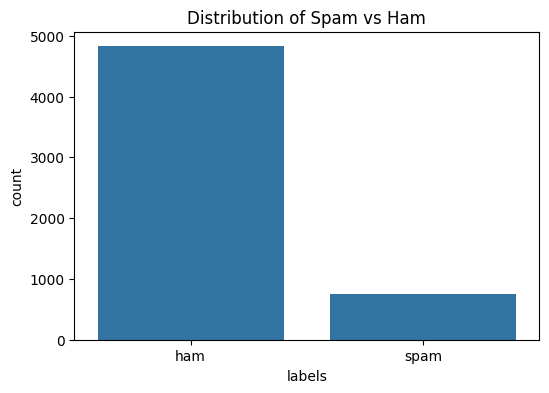

In [3]:
import pandas as pd

# Convertir le dataset en DataFrame pandas pour une manipulation plus facile
fr_data_df = fr_data.to_pandas()

print(fr_data_df['labels'].value_counts())

# Visualize it
plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=fr_data_df)
plt.title("Distribution of Spam vs Ham")
plt.show()

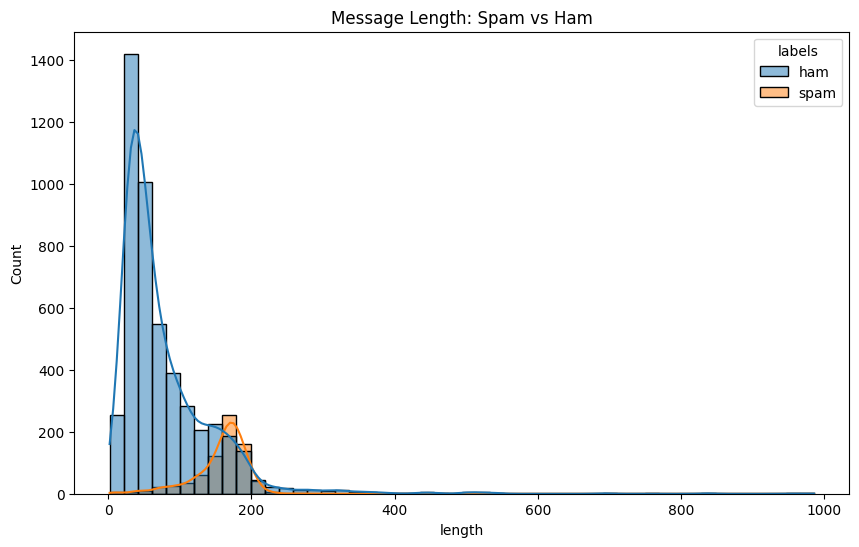

In [4]:
# Create a new column 'length'
fr_data_df['length'] = fr_data_df['text'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
sns.histplot(data=fr_data_df, x='length', hue='labels', bins=50, kde=True)
plt.title("Message Length: Spam vs Ham")
plt.show()

In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # URLs
    text = re.sub(r"\S+@\S+", " ", text)        # Emails
    text = re.sub(r"\d+", " ", text)            # Nombres
    text = re.sub(r"[^\w\s]", " ", text)        # Ponctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

fr_data_df["clean_text"] = fr_data_df["text"].apply(clean_text)

fr_data_df[["text", "clean_text"]].head()


,text,clean_text
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",allez jusqu à jurong point fou disponible seul...
1,J'ai fait une blague sur le wif u oni...,j ai fait une blague sur le wif u oni
2,Entrée libre dans 2 a wkly comp pour gagner FA...,entrée libre dans a wkly comp pour gagner fa c...
3,U dun dit si tôt hor... U c déjà dire alors...,u dun dit si tôt hor u c déjà dire alors
4,"Non, je ne pense pas qu'il va à usf, il vit da...",non je ne pense pas qu il va à usf il vit dans...


In [6]:
from sklearn.model_selection import train_test_split

X = fr_data_df["clean_text"]
y = fr_data_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 4457
Test size : 1115


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Get French stop words from NLTK
french_stop_words = stopwords.words('french')

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigram + bigram
    min_df=2,
    max_df=0.9,
    stop_words=french_stop_words # Use the list of French stop words
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Shape TF-IDF train:", X_train_tfidf.shape)
print("Shape TF-IDF test :", X_test_tfidf.shape)


Shape TF-IDF train: (4457, 7914)
Shape TF-IDF test : (1115, 7914)
